### Load Libraries

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from src.VAE_MNIST import MNISTEncoderV, MNISTDecoder
from src.utils.data_io import show_images, TensorDataset

### Conig parameter

In [3]:
# Configuration parameters
N = 32
MODEL_DIR_VAE = "./models/MNIST/VAE/"
MODEL_NAME = "VAE"

USE_BATCH_NORM = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = './data/MNIST/'

### Load pre-trained model

In [4]:
def load_models(n=N, use_batch_norm=USE_BATCH_NORM, device=DEVICE):
    """Load trained encoder and decoder models"""
    model_file_enc = MODEL_DIR_VAE + f"{n}_encoder.pth"
    model_file_dec = MODEL_DIR_VAE + f"{n}_decoder.pth"
    
    enc_model = MNISTEncoderV(N=n, use_BatchNorm=use_batch_norm).to(device)
    enc_model.load_state_dict(torch.load(model_file_enc, weights_only=True))
    enc_model.eval()
    
    dec_model = MNISTDecoder(N=n, use_BatchNorm=use_batch_norm).to(device)
    dec_model.load_state_dict(torch.load(model_file_dec, weights_only=True))
    dec_model.eval()
    
    return enc_model, dec_model

enc_model, dec_model = load_models()

### Generate images from random noise

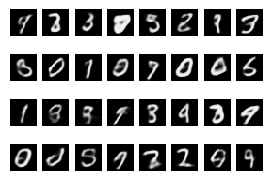

In [5]:
def generate_samples_from_normal_dist(decoder, n_samples=32, latent_dim=N, z_mu=0, z_sigma=1, device=DEVICE):
    """Generate images by sampling from latent space"""
    z = z_sigma * torch.randn((n_samples, latent_dim)).to(device) + z_mu
    
    with torch.inference_mode():
        generated_images = decoder(z)
        show_images(generated_images.to('cpu').detach(), num=n_samples, 
                   num_per_row=8, title=f'{N}_{MODEL_NAME}_generated_samples', save_fig=True, save_dir=f"./results/MNIST/{MODEL_NAME}/")
    
    return generated_images

gen_samples = generate_samples_from_normal_dist(dec_model, n_samples=32, latent_dim=N, z_mu=0, z_sigma=1)

### Load data

In [6]:
def load_mnist_data(data_dir=DATA_DIR):
    """Load MNIST dataset from files"""
    train_images = torch.load(os.path.join(data_dir, 'MNIST_train_images.pt'))
    train_labels = torch.load(os.path.join(data_dir, 'MNIST_train_labels.pt'))
    return train_images, train_labels

train_images, train_labels = load_mnist_data()
train_images.shape, train_labels.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([60000]))

### Select a balance of images

In [7]:
def select_balanced_samples(images, labels, samples_per_class=100):
    """Select equal number of samples from each class"""
    selected_indices = torch.cat([torch.where(labels == label)[0][:samples_per_class] 
                                 for label in range(10)])
    
    selected_images = images[selected_indices]
    selected_labels = labels[selected_indices]
    
    print(f"Selected images shape: {selected_images.shape}")
    
    # Verify class distribution
    unique_labels, counts = torch.unique(selected_labels, return_counts=True)
    for label, count in zip(unique_labels.tolist(), counts.tolist()):
        print(f"Label {label} count: {count}")
    
    return selected_images, selected_labels

selected_images, selected_labels = select_balanced_samples(train_images, train_labels, samples_per_class=100)

Selected images shape: torch.Size([1000, 1, 28, 28])
Label 0 count: 100
Label 1 count: 100
Label 2 count: 100
Label 3 count: 100
Label 4 count: 100
Label 5 count: 100
Label 6 count: 100
Label 7 count: 100
Label 8 count: 100
Label 9 count: 100


### Visualize the embedding

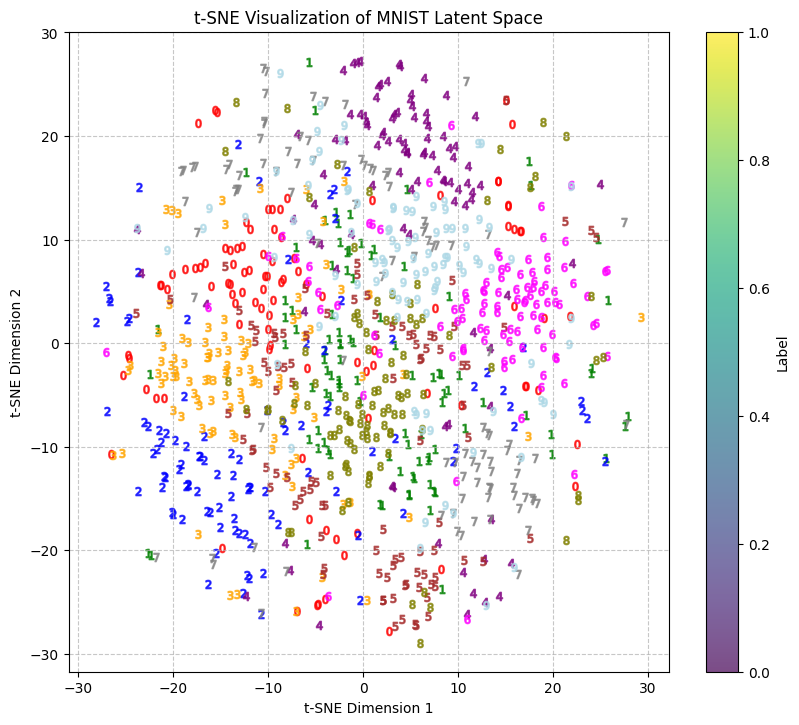

In [8]:
def visualize_latent_space(encoder, images, labels, device=DEVICE):
    """Visualize latent space using t-SNE"""
    # Generate embeddings
    with torch.inference_mode():
        embedding, mu, lnvar = encoder(images.to(device))
    
    # Convert to numpy for t-SNE
    embedding_np = embedding.cpu().numpy()
    
    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced_embedding = tsne.fit_transform(embedding_np)
    
    # Visualization
    plt.figure(figsize=(10, 8))
    colors = ["red", "green", "blue", "orange", "purple", 
              "brown", "fuchsia", "grey", "olive", "lightblue"]
    
    for point, label in zip(reduced_embedding, labels):
        plt.scatter(point[0], point[1], marker="${}$".format(label), 
                   c=colors[label], alpha=0.7)
    
    plt.title('t-SNE Visualization of MNIST Latent Space')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.colorbar(label='Label')
    
    plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1)
    save_path = os.path.join(f"./results/MNIST/{MODEL_NAME}", f"{embedding_np.shape[1]}_{MODEL_NAME}_tsne_visualization.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


visualize_latent_space(enc_model, selected_images, selected_labels, device=DEVICE)

### morph between two images

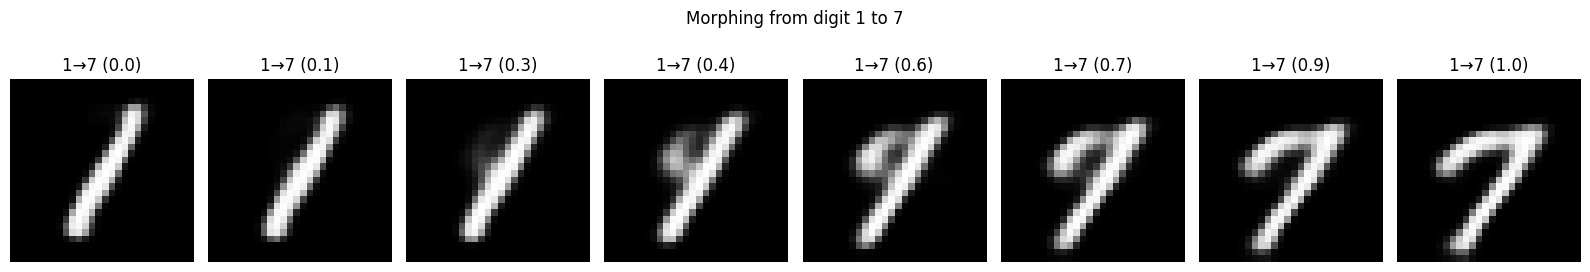

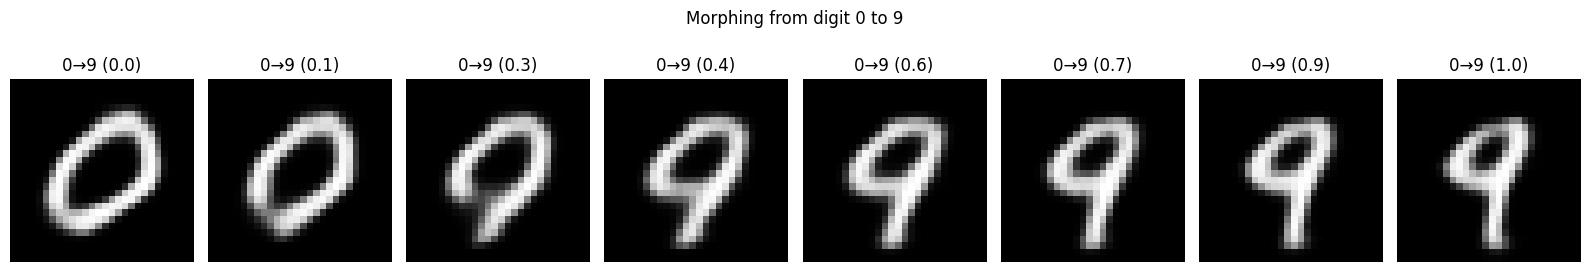

In [9]:
def morph_between_digits(encoder, decoder, images, labels, 
                       digit1, digit2, num_steps=10, device=DEVICE):
    """Generate morphing sequence between two digits"""
    # Find indices for the specified digits
    indices1 = torch.where(labels == digit1)[0]
    indices2 = torch.where(labels == digit2)[0]
    
    if len(indices1) == 0 or len(indices2) == 0:
        print(f"Digit {digit1} or {digit2} not found.")
        return
    
    # Get sample images
    img1 = images[indices1[0]].unsqueeze(0).to(device)
    img2 = images[indices2[0]].unsqueeze(0).to(device)
    
    # Get latent representations
    with torch.inference_mode():
        z1, _, _ = encoder(img1)
        z2, _, _ = encoder(img2)
    
    # Prepare visualization
    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps * 2, 3))
    
    # Generate interpolated images
    for i in range(num_steps):
        alpha = i / (num_steps - 1) if num_steps > 1 else 0
        z_interp = (1 - alpha) * z1 + alpha * z2
        
        with torch.inference_mode():
            img_interp = decoder(z_interp)
        
        img_np = img_interp.cpu().squeeze().detach().numpy()
        axes[i].imshow(img_np, cmap='gray')
        axes[i].set_title(f"{digit1}→{digit2} ({alpha:.1f})")
        axes[i].axis('off')
    
    plt.suptitle(f"Morphing from digit {digit1} to {digit2}")
    plt.tight_layout()
    save_path = os.path.join(f"./results/MNIST/{MODEL_NAME}", f"{z1.shape[1]}_{MODEL_NAME}_morphing_{digit1}_to_{digit2}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


# Demonstrate morphing between digits
morph_between_digits(enc_model, dec_model, selected_images, selected_labels, digit1=1, digit2=7, num_steps=8)
morph_between_digits(enc_model, dec_model, selected_images, selected_labels, digit1=0, digit2=9, num_steps=8)